Imported Needed Libraries

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report 
import joblib
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')



modules loaded


Read Data

In [2]:
data_dir='/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
target_folder='Brain Cancer'
filepath=[]
labels=[]
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath=os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)  

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
df = pd.concat([f_series, l_series], axis=1)

In [3]:
df

,filepath,labels
0,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
1,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
2,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
3,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
4,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
...,...,...
14995,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_menin
14996,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_menin
14997,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_menin
14998,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_menin


Display amount of Labels

In [4]:
count_df=df['labels'].value_counts().reset_index()
count_df.columns=['labels','count']
fig_df=px.bar(count_df,x='labels',y='count',title='count of labels in df',text_auto=True)
fig_df.show()

Split Data

In [5]:
strat=df['labels']
train_df,dummy_df=train_test_split(df,test_size=0.2,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [6]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(12000, 2)
(1500, 2)
(1500, 2)


Visualization

In [7]:
count_train=train_df['labels'].value_counts().reset_index()
count_train.columns=['labels','count']
fig_train=px.bar(count_train,x='labels',y='count',title='count of labels in train_df',text_auto=True)
fig_train.show()


In [8]:
count_valid=valid_df['labels'].value_counts().reset_index()
count_valid.columns=['labels','count']
fig_valid=px.bar(count_valid,x='labels',y='count',title='count of labels in valid_df',text_auto=True)
fig_valid.show()


In [9]:
count_test=test_df['labels'].value_counts().reset_index()
count_test.columns=['labels','count']
fig_test=px.bar(count_test,x='labels',y='count',title='count of labels in test_df',text_auto=True)
fig_test.show()


Data Augmentation

In [10]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)


Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


Sample of Data

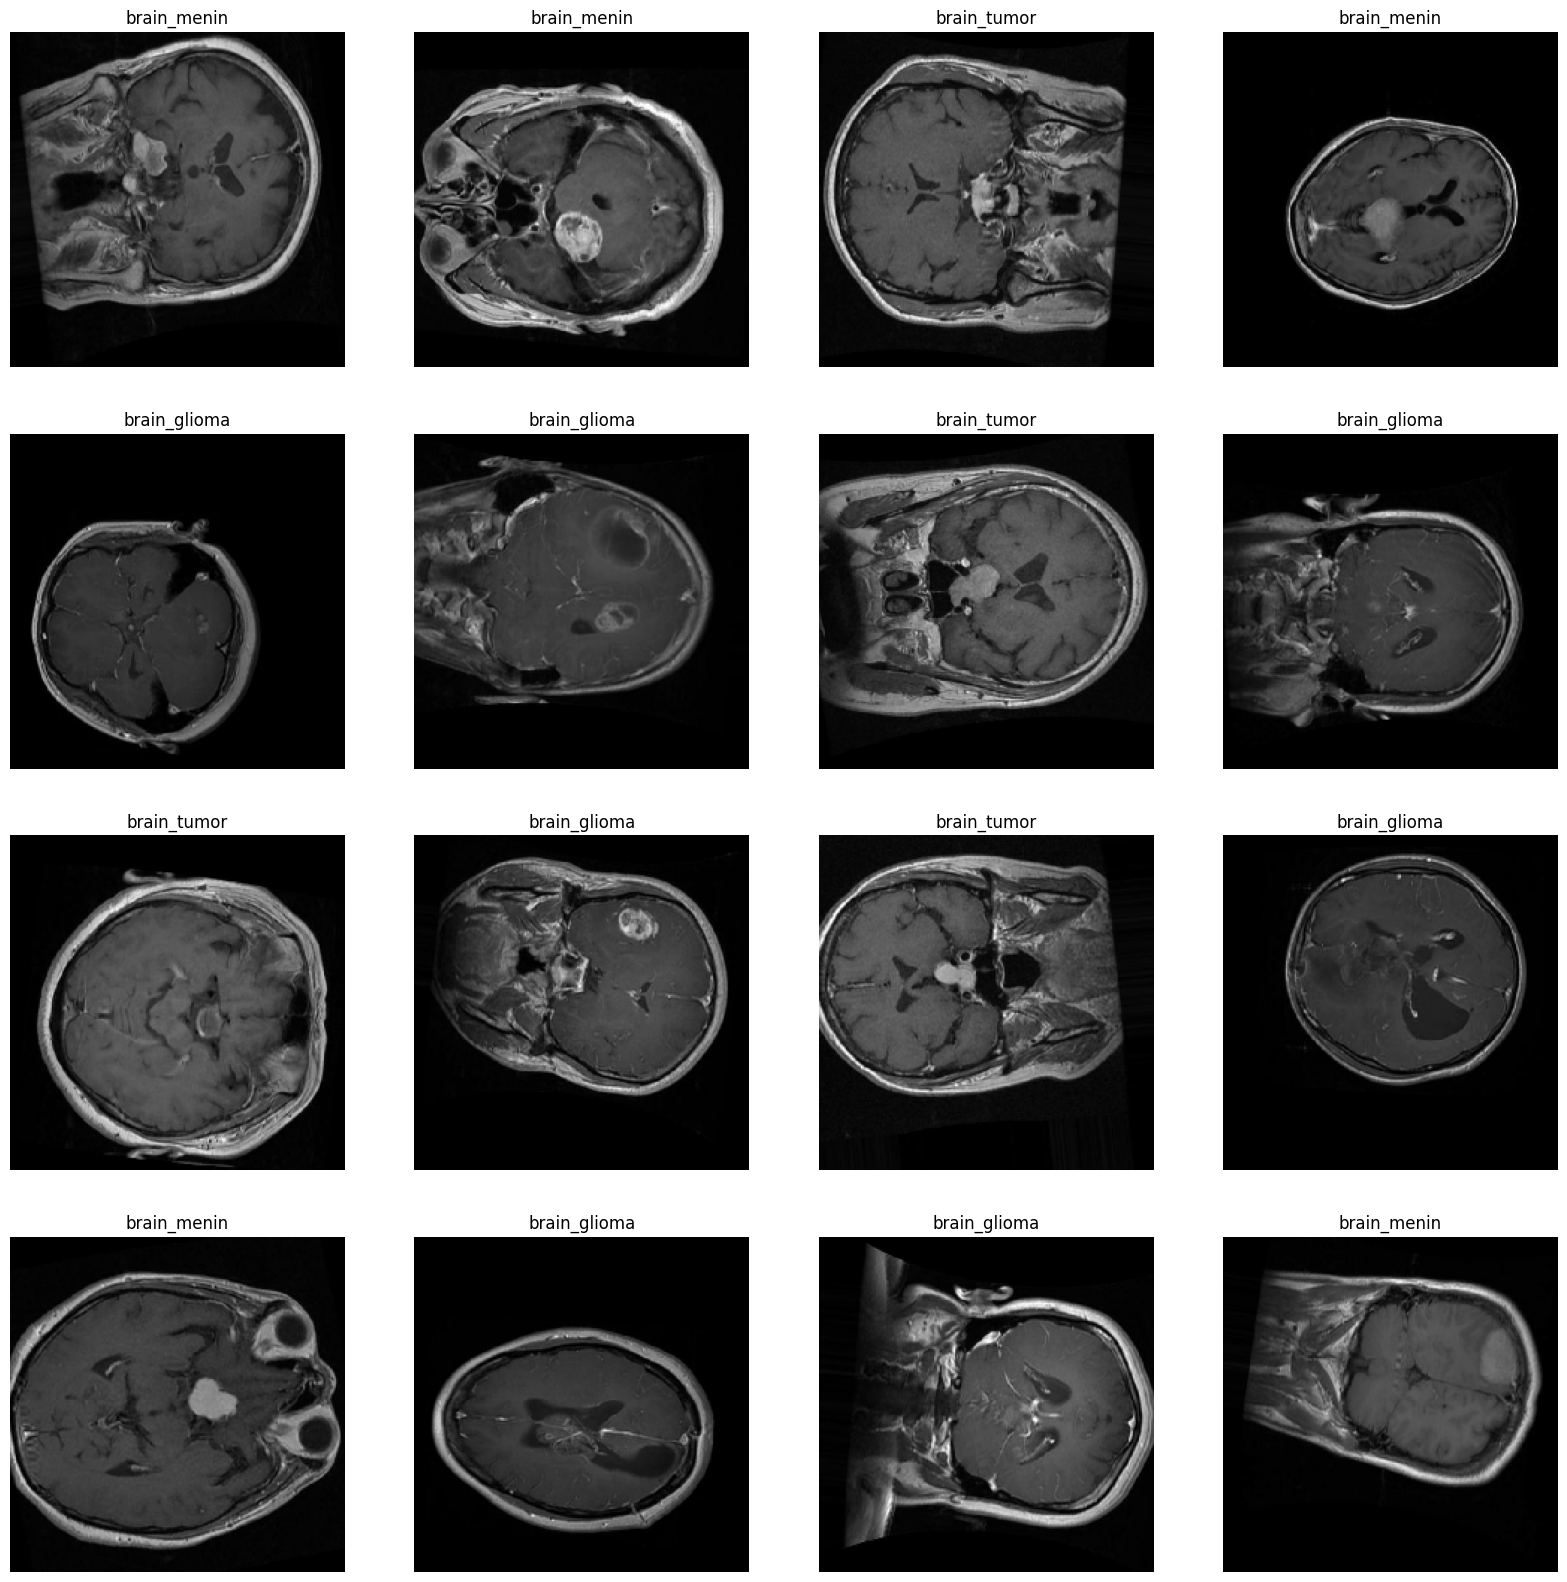

In [11]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(train_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

Build Model

In [12]:
base_model=keras.applications.EfficientNetB0(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(64,activation='relu'),
    Dense(len(classes),activation='softmax')
])
model.compile(Adamax(learning_rate= 0.01), loss= 'categorical_crossentropy', metrics= ['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_gen,epochs=100,validation_data=valid_gen,shuffle=False,
                  callbacks=[early_stopping])

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 212s 782ms/step - accuracy: 0.7123 - loss: 7.4581 - val_accuracy: 0.4420 - val_loss: 4.6311
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 240ms/step - accuracy: 0.9515 - loss: 0.1408 - val_accuracy: 0.9320 - val_loss: 0.2760
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - accuracy: 0.9683 - loss: 0.0943 - val_accuracy: 0.9687 - val_loss: 0.0945
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.9779 - loss: 0.0731 - val_accuracy: 0.9767 - val_loss: 0.0727
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 244ms/step - accuracy: 0.9848 - loss: 0.0453 - val_accuracy: 0.9860 - val_loss: 0.0376
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 241ms/step - accuracy: 0.9886 - loss: 0.0348 - val_accuracy: 0.9487 - val_loss: 0.1684
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.9888 - loss: 0.0317 - val_accuracy: 0.9633 - val_loss: 0.0932
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 240ms/step - accuracy: 0.9878 

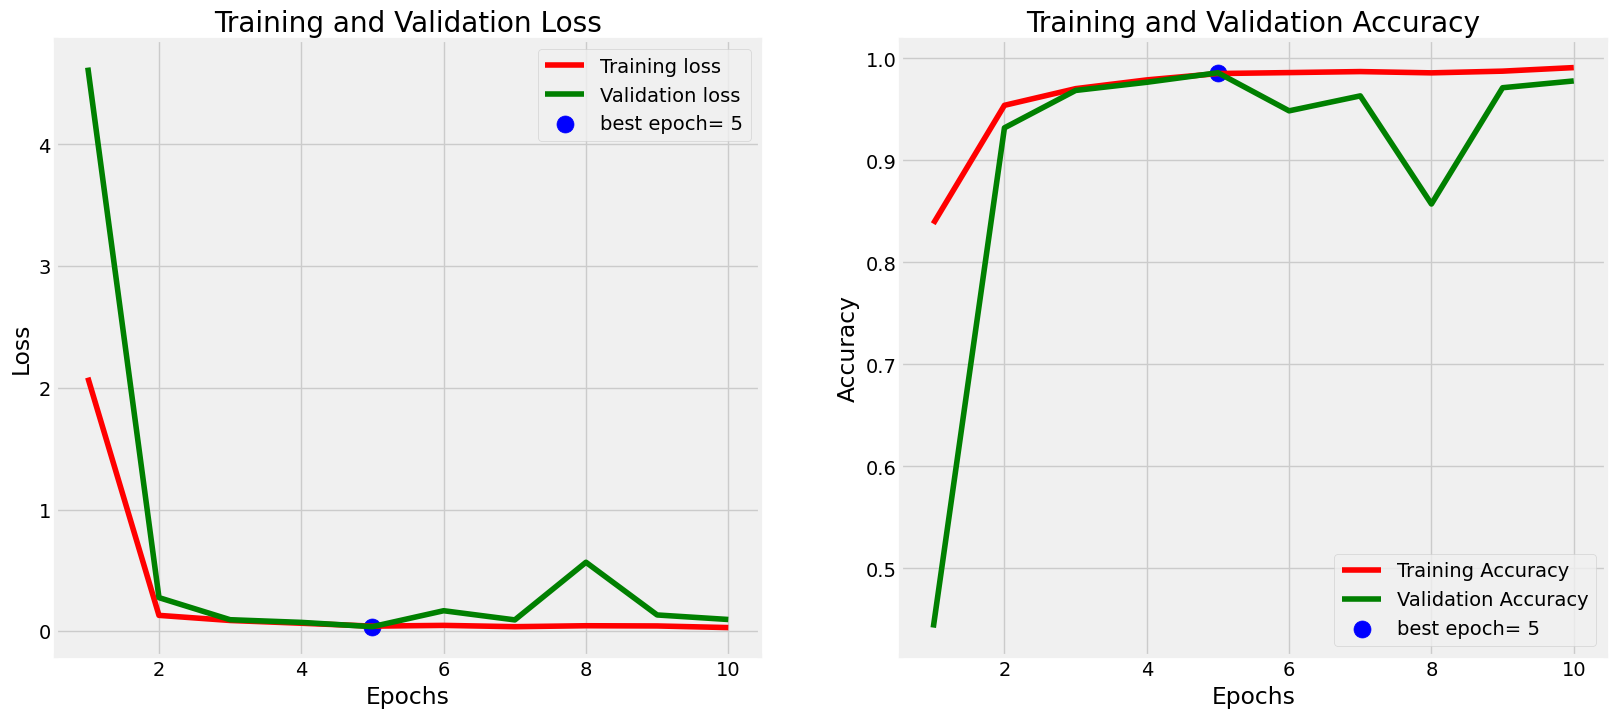

In [14]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

Evaluation

In [1]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

NameError: name 'test_df' is not defined

Predict

In [15]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 702ms/step


Confusion Matrix

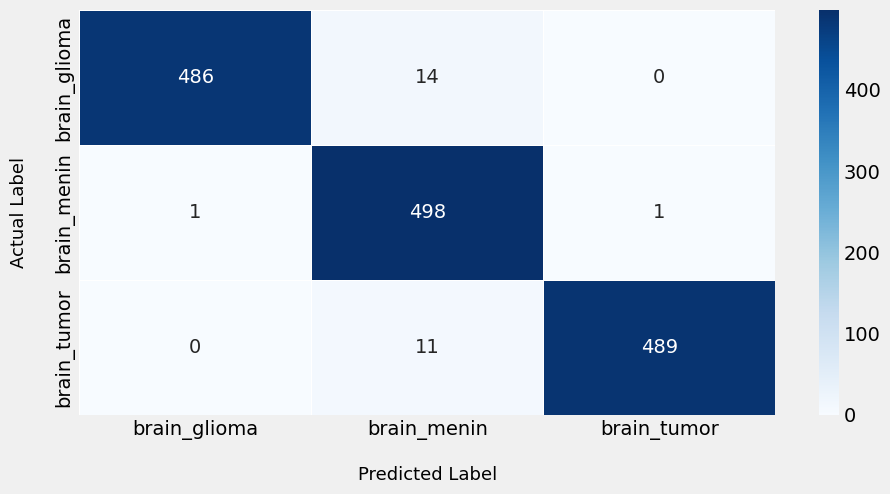

In [16]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);


Classification Report

In [17]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


              precision    recall  f1-score   support

brain_glioma       1.00      0.97      0.98       500
 brain_menin       0.95      1.00      0.97       500
 brain_tumor       1.00      0.98      0.99       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



Save Model

In [18]:
joblib.dump(model,"Brain Cancer classification.pkl")

['Brain Cancer classification.pkl']